In [1]:
# Data
import numpy as np
import pandas as pd

# Image
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# Machine-learning

## Model
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

## Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

## Model metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Others

## Creat Tree Image
from sklearn import tree
import pydotplus
from IPython.display import Image

## Config warnings
import warnings

# Settings
warnings.filterwarnings('ignore')
pd.set_option('precision', 2)
pd.options.display.max_columns = None # Show all columns
pd.options.display.max_rows = None # Show all columns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
datafile = 'data.csv'
data = pd.read_csv(datafile)

In [3]:
data.head()

,group,age,sex,education,profession,income,companion,selfcare,children,intimacy
0,0,1,2,3,1,4,3,4,2,4
1,0,1,2,3,5,5,5,4,2,4
2,0,1,2,5,1,5,3,4,2,4
3,1,1,2,5,4,4,3,4,2,4
4,1,1,2,5,5,5,3,4,1,4


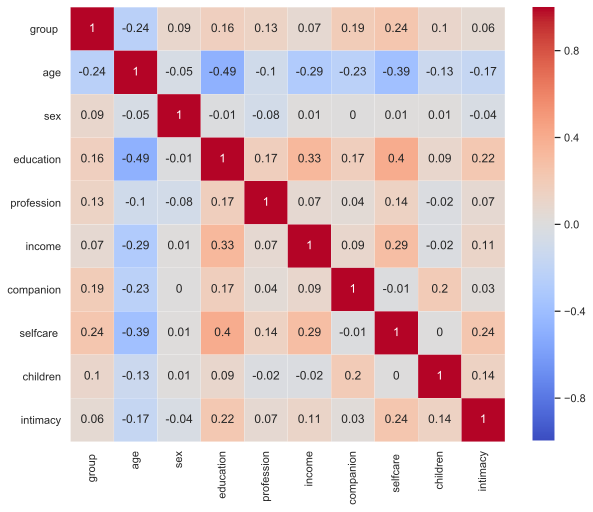

In [10]:
plt.figure(figsize=(10,8))

sns.heatmap(round(data.corr(method='kendall'),2),
            linewidths=0.1,
            square=True,
            cmap='coolwarm',
            linecolor='white',
            annot=True,
            vmax=1,
            vmin=-1);
plt.savefig('Heatmap.svg')

In [5]:
seed =42
testsize = 0.10
kfold = StratifiedKFold(n_splits=10, random_state =seed)
X, y = data.values[:,1:], data.values[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=seed)

   models  f1_score  cv_std
0      LR      0.29    0.11
1     LDA      0.29    0.11
2     QDA      0.46    0.14
3     SVM      0.39    0.11
4     KNN      0.46    0.09
5    CART      0.76    0.10
6     RFC      0.73    0.12
7     ETC      0.79    0.10
8     ABC      0.42    0.16
9     GBC      0.58    0.10
10   XGBC      0.58    0.15
11   MLPC      0.48    0.16


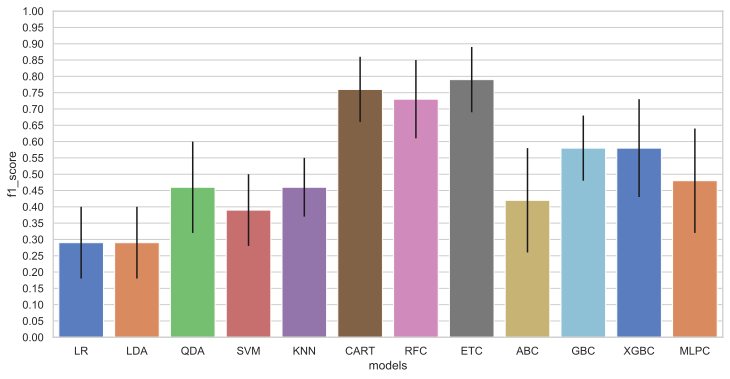

In [12]:
models = {
    'LR'  : LogisticRegression(),
    'LDA' : LinearDiscriminantAnalysis(),
    'QDA' : QuadraticDiscriminantAnalysis(),
    'SVM' : SVC(),
    'KNN' : KNeighborsClassifier(),
    'CART': DecisionTreeClassifier(random_state=seed),
    'RFC' : RandomForestClassifier(random_state=seed),
    'ETC' : ExtraTreesClassifier(random_state=seed),
    'ABC' : AdaBoostClassifier(),
    'GBC' : GradientBoostingClassifier(random_state=seed),
    'XGBC' : XGBClassifier(),
    'MLPC': MLPClassifier(random_state=seed)
}

cv_results = []
for key in models: 
        cv_score = cross_val_score(models[key], X_train, y_train, cv=kfold, scoring="f1")
        cv_mean = round(cv_score.mean(), 2)
        cv_std = round(cv_score.std(), 2)
        cv_result = {'models': key, 'f1_score': cv_mean, 'cv_std': cv_std}
        cv_results.append(cv_result)
cv_results = pd.DataFrame(cv_results)

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
cv_plot = sns.barplot(x='models', y='f1_score', data=cv_results, palette="muted", **{'yerr': cv_results['cv_std']});
cv_plot.set_yticks(np.arange(0, 1.05, 0.05));
plt.savefig('Model_Selection.svg')
print(cv_results)

In [13]:
parameters = {
                'max_depth': range(1,20),
                'max_features': range(1,15)
                
}#'min_samples_leaf':range(1,2,3), 'min_samples_split':range(2,3,4),'max_features': range(1,15),

grid_init = GridSearchCV(models['CART'], param_grid=parameters,scoring='f1', cv=kfold)
grid_fit = grid_init.fit(X_train, y_train)
model = grid_fit.best_estimator_
cv_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring="f1")
cv_mean = round(cv_score.mean(), 2)
cv_std = round(cv_score.std(), 2)
print('cv_mean: ', cv_mean)
print('cv_std: ', cv_std)
best_estimator = grid_fit.best_estimator_
best_estimator.fit(X_train, y_train)

cv_mean:  0.77
cv_std:  0.11


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=17, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [14]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test) # 决策树的二分类每个点proba是0或者1
result = pd.DataFrame(X_test, columns=data.columns[1:])
result['label'] = y_test
result['pred'] = y_pred
result['result'] = y_pred - y_test
correct_data = result[result['result']==0]
wrong_data = result[result['result']!=0]

In [15]:
correct_data

,age,sex,education,profession,income,companion,selfcare,children,intimacy,label,pred,result
0,3,2,1,2,3,1,4,1,2,0,0,0
1,1,2,3,4,3,1,4,1,4,1,1,0
2,3,2,1,1,2,1,1,0,0,0,0,0
3,5,2,1,3,1,2,4,1,3,1,1,0
4,1,2,2,1,4,1,4,2,3,0,0,0
5,1,1,5,3,4,3,4,2,4,0,0,0
7,2,2,2,5,1,3,4,2,4,1,1,0
8,3,1,1,2,1,4,3,2,3,0,0,0
9,4,2,3,2,5,4,4,0,0,1,1,0
10,3,2,2,2,3,1,4,1,4,0,0,0


In [18]:
wrong_data

,age,sex,education,profession,income,companion,selfcare,children,intimacy,label,pred,result
6,1,2,3,1,2,3,4,2,2,0,1,1
20,2,2,5,2,3,1,4,2,3,1,0,-1
22,1,2,5,1,5,3,4,2,4,0,1,1
35,1,1,5,1,2,4,1,3,2,0,1,1
37,1,1,3,5,3,1,4,1,4,1,0,-1
41,1,2,5,2,2,3,4,1,2,0,1,1
47,3,2,5,3,3,1,4,0,0,1,0,-1


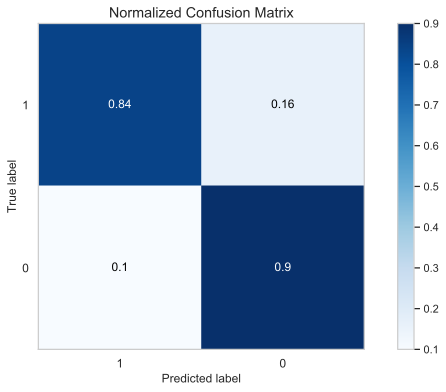

In [20]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, labels=[1,0], figsize=(12,6));
plt.savefig('Confusion_Matrix.svg')

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        40
           1       0.80      0.84      0.82        19

    accuracy                           0.88        59
   macro avg       0.86      0.87      0.87        59
weighted avg       0.88      0.88      0.88        59



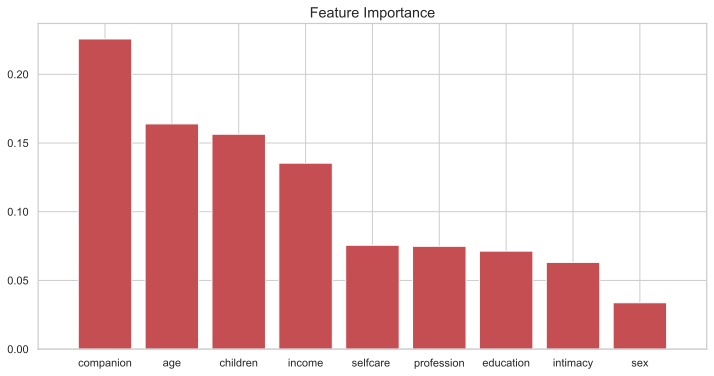

In [23]:
skplt.estimators.plot_feature_importances(model, feature_names=data.columns[1:], figsize=(12,6), text_fontsize=11);
plt.savefig('Feature_Importance.svg')

In [25]:
dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=data.columns[1:],  
                         class_names=['alive','dead'],  
                         filled=True, rounded=True,  
                         special_characters=True,
                         max_depth=2)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 
graph.write_svg('CART_Tree.svg')

True

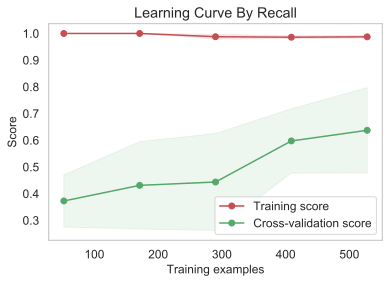

In [27]:
skplt.estimators.plot_learning_curve(model, X, y, cv=kfold, random_state=seed, scoring='f1', title='Learning Curve By Recall');
plt.savefig('Learning_Curve.svg')

### 7.2 PR曲线

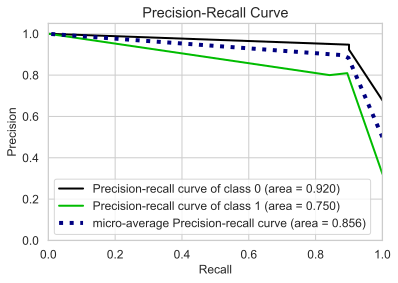

In [29]:
skplt.metrics.plot_precision_recall(y_test, y_proba);
plt.savefig('PR_Curve.svg')

### 7.3 ROC曲线

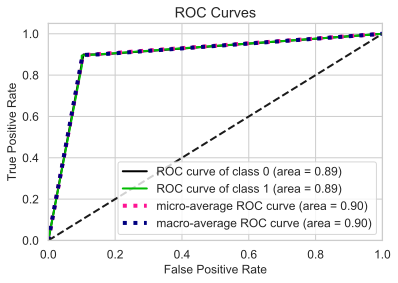

In [31]:
skplt.metrics.plot_roc(y_test, y_proba);
plt.savefig('ROC_Curve.svg')